<h1>Pricing Options With Methods from Stochastic Calculus and Monte Carlo Methods</h1>

<p>Pricing vanilla options and a few other type of options such as digital options is analytically tractable using methods from stochastic calculus and Black Scholes option pricing formula. Exotic options such as Parisian options or Bermudan options does not yet have any anlytical solution. These options can sometimes be priced efficiently using numerical methods. However, numerical methods offen suffer from the "curse of dimensionality". The "curse of dimensionality" refers to the exponentially growing runtime complexity of numerical methods. To overcome this Monte Carlo methods are often employed due to their ability to price high-dimensionality options. However, this often come at the price of reduced accuracy.</p>

<p>In this presentation we will:</p>
<ol>
    <li>Price an option using methods from stochastic calculus. Price the same option using Monte Carlo to verify that it works.</li>
    <li>Price the same option again using Monte Carlo with importance sampling.</li>
    <li>Price a Parisian option using Monte Carlo without and with antithetic sampling.</li>
</ol>


In [139]:
# importing libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# setting important parameters
s0 = 100
K = 110
sigma = 0.05
tau = 1
r = 0.05
trigger = 0.3 # time spent in the money to trigger payoff for parisian

N = 1000  # number of simulations to run in MC
B = 1000 # number of bootstrap samples
time_steps = 100
time = np.linspace(0, tau, time_steps)

In [140]:
def black_scholes(s0, K, sigma, tau, r):
    d1 = (np.log(s0/K) + (r+sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return norm.cdf(d1)*s0 - norm.cdf(d2)*K*np.exp(-r*tau)

def monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic = False):
    dt = tau/time_steps
    if antithetic:
        dW = np.random.normal(size=(N//2, time_steps))
        random_walks = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW
        random_walks_anti = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*(-dW)

        random_walks = np.vstack([random_walks, random_walks_anti])
    else:
        dW = np.random.normal(size=(N, time_steps))
        random_walks = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW

    random_walks = random_walks.cumsum(axis=1)
    random_walks = s0*np.exp(random_walks)
    final_values = random_walks[:, -1]
    mc_call_value = np.exp(-r*tau)*np.mean(np.maximum(final_values - K, 0))
    

    return mc_call_value, random_walks

def monte_carlo_parisian(s0, K, sigma, tau, r, trigger, N, time_steps, antithetic = False):
    dt = tau/time_steps
    random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic)[1]

    time_spent_itm = np.sum(np.where(random_walks >= K, dt, 0), axis = 1)
    final_values = random_walks[:, -1]
    payoff = np.exp(-r*tau)*np.mean(np.where((final_values >= K) & (time_spent_itm >= trigger), final_values-K, 0))


    random_walks_itm = random_walks[(final_values >= K) & (time_spent_itm >= trigger), :]
    random_walks_otm = random_walks[~((final_values >= K) & (time_spent_itm >= trigger)), :]

    return payoff, random_walks_itm, random_walks_otm
    


<h3>1. Price an option using methods from stochastic calculus. Price the same option using Monte Carlo to verify that it works.</h3>

Using Monte Carlo is quite straightforward. First we simulate different price paths according to the geometric brownian motion $dS_t = \mu S_t dt + \sigma dW_t $ where $\mu = r-\frac{1}{2}\sigma$. After simulating the price paths we calculate the payoff of at maturity $T$ of call $i$ corresponding to the $i$-th simulated pricepath $C_{T, i} = \max(S_T-K, 0)$. Taking the average payoff $\bar{C} = \frac{1}{N}\sum_{i=1}^{N} C_{T,i}$ and discounting by a factor $e^{-rt}$ will give us the price for a call option. That is $C \simeq \bar{C}e^{-rt}$.


Pricing with Monte Carlo: 0.5609643506476175
Pricing with Black Scholes: 0.5077505432245673


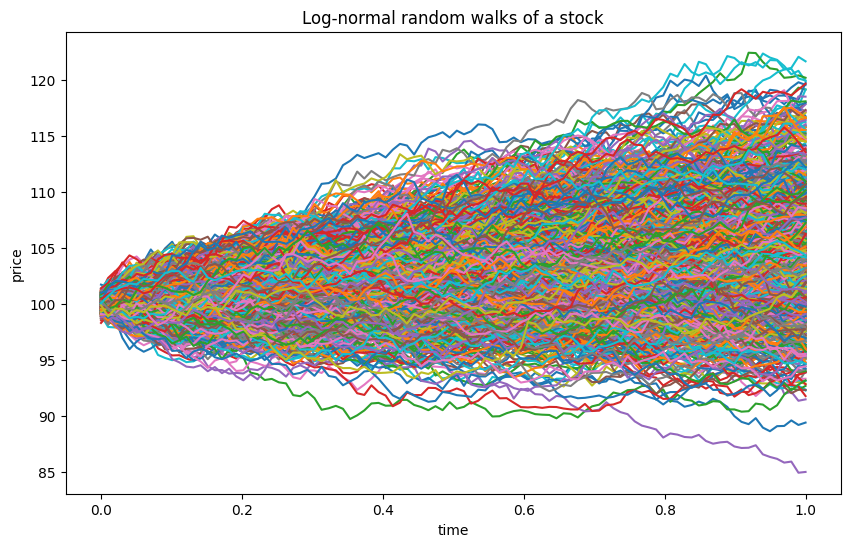

In [141]:
mc_call_value, random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps)
bs_call_value = black_scholes(s0, K, sigma, tau, r)


print(f"Pricing with Monte Carlo: {mc_call_value}")
print(f"Pricing with Black Scholes: {bs_call_value}")


plt.figure(figsize=(10, 6))
plt.plot(time, random_walks.T)
plt.xlabel("time")
plt.ylabel("price")
plt.title("Log-normal random walks of a stock")
plt.show()

<h5>1.2 Bootstrapping the Monte Carlo estimates</h5>

We did get quite a good estimate using Monte Carlo methods. However, this estimate is not deterministic, so we are interested in the variance. We can estimate the variance using bootstrapping. That is we simulate $\bar{C}^b, b \in [1,\dots,B]$. We then calculate the empirical mean and variance of $\bar{C}$.

In [142]:
bootstrapped_mc_call = []

for i in range(B):
    bootstrapped_mc_call.append(monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps)[0])

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"True value of call: {bs_call_value}")
print(f"Variance of bootstrapped estimates: {np.var(bootstrapped_mc_call)}")


Mean of bootstrap estimates: 0.5084097512744598
True value of call: 0.5077505432245673
Variance of bootstrapped estimates: 0.0021668299526883122


<h5>1.3 Reducing the variance</h5>

We want as presice measures as possible. We can achieve this through antithetic sampling. Given samples $X_i, i \in [1,\dots, n]$ you create antithetic samples $\tilde{X_i} = -X_i, i \in [1,\dots, n]$. Making the antithetic samples the negative of the original samples induces negative correlation between the samples and reduces the variance. We know that the variance of $2n$ samples from previous calculations is $\text{Var}[\frac{1}{2n}\sum_{1}^{2n}X_i] = \frac{1}{2n}\sigma^2$ The variance with the antithetic samples can be written as:

\begin{align*}
    \text{Var[samples + antithetic samples]} &= \text{Var}[\frac{1}{2n}\sum_{i=1}^{n}X_i + \frac{1}{2n}\sum_{i=1}^{n}\tilde{X_i}] \\
    &=\frac{1}{(2n)^2}\text{Var}[\sum_{i=1}^{n}X_i] + \frac{1}{(2n)^2}\text{Var}[\sum_{i=1}^{n}\tilde{X_i}] + 2\text{Cov}[\sum_{i=1}^{n}X_i, \sum_{1}^{n}\tilde{X_i}]\\
    &= \frac{n}{(2n)^2}\sigma^2 + \frac{n}{(2n)^2}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{2n}{(2n)^2}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{1}{2n}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &< \frac{1}{2n}\sigma^2
\end{align*}

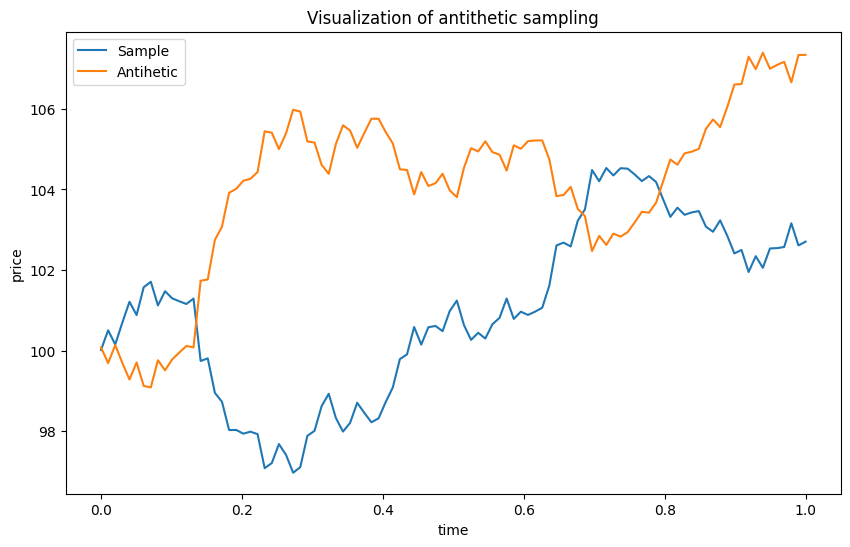

In [143]:
mc_call_value, random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, 2, time_steps, antithetic=True)

plt.figure(figsize=(10, 6))
plt.plot(time, random_walks.T, label=["Sample", "Antihetic"])
plt.legend()
plt.xlabel("time")
plt.ylabel("price")
plt.title("Visualization of antithetic sampling")
plt.show()

In [144]:
bootstrapped_mc_call = []

for i in range(B):
    bootstrapped_mc_call.append(monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic=True)[0])

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"True value of call: {bs_call_value}")
print(f"Variance of bootstrapped estimates: {np.var(bootstrapped_mc_call)}")

Mean of bootstrap estimates: 0.507081759644537
True value of call: 0.5077505432245673
Variance of bootstrapped estimates: 0.00191970623523931


<h3>2. Price the same option again using Monte Carlo with antihetic sampling.</h3>

Let us change the setup a bit. Now we know that the call will end up 10 in the money. We can still price the option with stochastic calculus. We know that 

<h3>3. Pricing Parisian option using Monte Carlo with antithetic sampling</h3>

Antithetic sampling:

Given samples $X_i, i \in [1,\dots, n]$ you create antithetic samples $\tilde{X_i} = -X_i, i \in [1,\dots, n]$. Making the antithetic samples the negative of the original samples induces negative correlation between the samples and reduces the variance. We know that the variance of $2n$ samples from previous calculations is $\text{Var}[\frac{1}{2n}\sum_{1}^{2n}X_i] = \frac{1}{2n}\sigma^2$ The variance with the antithetic samples can be written as:

\begin{align}
    \text{Var[samples + antithetic samples]} &= \text{Var}[\frac{1}{2n}\sum_{1}^{n}X_i + \frac{1}{2n}\sum_{1}^{n}\tilde{X_i}] \\
    &=\frac{1}{(2n)^2}\text{Var}[\sum_{1}^{n}X_i] + \frac{1}{(2n)^2}\text{Var}[\sum_{1}^{n}\tilde{X_i}] + 2\text{Cov}[\sum_{1}^{n}X_i, \sum_{1}^{n}\tilde{X_i}]\\
    &= \frac{n}{(2n)^2}\sigma^2 + \frac{n}{(2n)^2}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{2n}{(2n)^2}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{1}{2n}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &< \frac{1}{2n}\sigma^2

\end{align}

Pricing parisian option with Monte Carlo: 0.2789589939555484


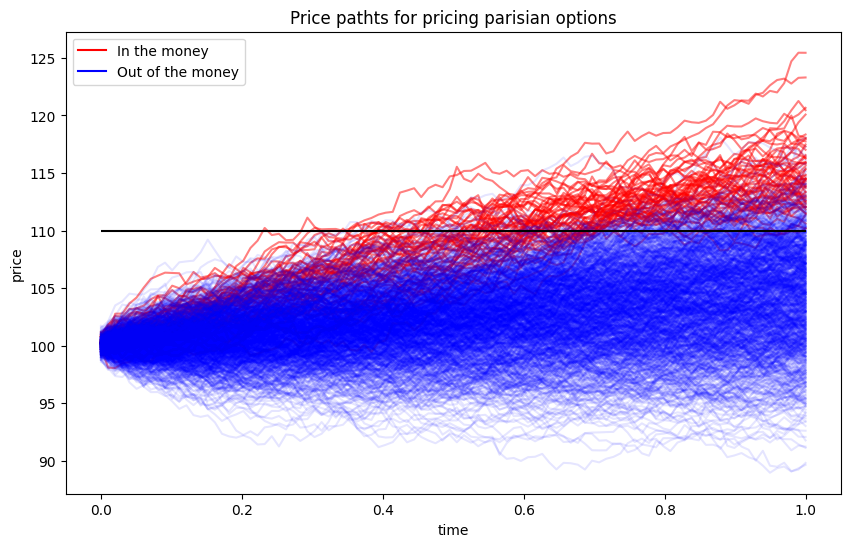

In [145]:
mc_parisian_value, random_walks_itm, random_walks_otm = monte_carlo_parisian(s0, K, sigma, tau, r, trigger, N, time_steps)


print(f"Pricing parisian option with Monte Carlo: {mc_parisian_value}")


plt.figure(figsize=(10, 6))
plt.plot(time, random_walks_itm.T, color="red", alpha=0.5)
plt.plot(time, random_walks_otm.T, color="blue", alpha=0.1)
plt.plot([], [], color="red", label="In the money")
plt.plot([], [], color="blue", label="Out of the money")
plt.legend()
plt.hlines(K, xmin=0, xmax=tau, label="Strike", color="black")
plt.xlabel("time")
plt.ylabel("price")
plt.title("Price pathts for pricing parisian options")
plt.show()


In [146]:
# code using antithetic sampling